In [93]:
import datetime
import time
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from functools import reduce
from tqdm.notebook import tqdm
import warnings
import json
import re
import math
# 模型训练及测试
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
import pydotplus
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import joblib
from IPython.display import Image

# from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
# from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids, NearMiss
# from imblearn.combine import SMOTEENN, SMOTETomek

# 画图
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['font.family']='sans-serif'

from dtreeviz.trees import dtreeviz, explain_prediction_path

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 5000)

In [135]:
def get_bin(sample_df_raw, column):
    b = sorted(set([-np.inf
#                     , np.quantile(sample_df_raw[column], 0.1)
                    , np.quantile(sample_df_raw[column], 0.2)
#                     , np.quantile(sample_df_raw[column], 0.3)
                    , np.quantile(sample_df_raw[column], 0.4)
#                     , np.quantile(sample_df_raw[column], 0.5)
                    , np.quantile(sample_df_raw[column], 0.6)
#                     , np.quantile(sample_df_raw[column], 0.7)
                    , np.quantile(sample_df_raw[column], 0.8)
#                     , np.quantile(sample_df_raw[column], 0.9)
                    , np.inf]))
    return pd.cut(sample_df_raw[column], b)


def get_metrics(sample_df, column, y, psi_split):
    tmp_df = sample_df[['下单时间', column, y]].copy(deep=True)
    tmp_df = tmp_df[tmp_df[column]!=-9999].reset_index(drop=True)
    
    total = tmp_df.shape[0]
    bad = tmp_df[tmp_df[y]==1].shape[0]
    good = tmp_df[tmp_df[y]==0].shape[0]
    badratio = bad/total
    
    
    tmp_df[column+'_bin'] = get_bin(sample_df, column)
    column_df = tmp_df.groupby(column+'_bin')[y].agg([np.size, np.sum]).reset_index().dropna(axis=0, how='any')
    column_df.columns = ['分箱', '个数', '坏样本']
    column_df['特征'] = column
    column_df['整体个数'] = total
    column_df['整体坏样本'] = bad
    column_df['整体好样本'] = good
    column_df['整体badratio'] = badratio
    column_df['好样本'] = column_df['个数'] - column_df['坏样本']
    column_df['badratio'] = column_df['坏样本']/column_df['个数']
    column_df['累计badrate'] = column_df['坏样本'].cumsum()/bad
    column_df['累计goodrate'] = column_df['好样本'].cumsum()/good
    column_df['KS分量'] = abs(column_df['累计badrate'] - column_df['累计goodrate'])
    column_df['KS'] = max(column_df['KS分量'])
    column_df['WOE'] = np.log((column_df['好样本']/good)/(column_df['坏样本']/bad))
    column_df['IV'] = sum((column_df['好样本']/good - column_df['坏样本']/bad)*column_df['WOE'])
#     column_df['lift'] = column_df['badratio']/badratio
#     column_df['minlift'] = min(column_df['lift'])
#     column_df['maxlift'] = max(column_df['lift'])
#     column_df['上累计lift'] = (column_df['坏样本'].cumsum()/column_df['个数'].cumsum())/badratio
#     column_df['下累计lift'] = ((bad-column_df['坏样本'].cumsum())/(total-column_df['个数'].cumsum()))/badratio
#     column_df['max上累计lift'] = max(column_df['上累计lift'])
#     column_df['max下累计lift'] = max(column_df['下累计lift'])
    
    Actual = tmp_df[tmp_df['下单时间']>psi_split]
    Expect = tmp_df[tmp_df['下单时间']<=psi_split]
    ashape = Actual.shape[0]
    eshape = Expect.shape[0]
    apsi_df = Actual.groupby(column+'_bin')[y].agg(np.size).reset_index()
    epsi_df = Expect.groupby(column+'_bin')[y].agg(np.size).reset_index()
    apsi_df.columns = ['分箱', 'a个数']
    epsi_df.columns = ['分箱', 'e个数']
    apsi_df['a占比'] = apsi_df['a个数']/ashape
    epsi_df['e占比'] = epsi_df['e个数']/eshape
    apsi_df['a占比'] = apsi_df['a占比'].fillna(0)
    epsi_df['e占比'] = epsi_df['e占比'].fillna(0)
    psi_df = apsi_df.merge(epsi_df, on='分箱', how='left')
    psi_df['PSI分量'] = (psi_df['a占比']-psi_df['e占比'])*np.log(psi_df['a占比']/psi_df['e占比'])
    psi_df['PSI分量'] = psi_df['PSI分量'].replace(np.inf, 0)
    column_df = column_df.merge(psi_df, on='分箱', how='left')
    column_df['PSI'] = sum(column_df['PSI分量'])
    

    floor = np.quantile(tmp_df[column], 0.05)
    roof = np.quantile(tmp_df[column], 0.95)
    tmp_cut = set(tmp_df[(tmp_df[column]>=floor)&(tmp_df[column]<=roof)][column])

    # bestlift
    maxlift = 0
    minlift = 1
    maxliftcut = floor
    minliftcut = floor

    for c in tmp_cut:
        tmp_df[column+'_bin2'] = pd.cut(tmp_df[column], [-np.inf, c, np.inf])
        tmp_column_df = tmp_df.groupby(column+'_bin2')[y].agg([np.size, np.sum]).reset_index().dropna(axis=0, how='any')
        tmp_column_df.columns = ['分箱', '个数', '坏样本']
        tmp_column_df['特征'] = column
        tmp_column_df['badratio'] = tmp_column_df['坏样本']/tmp_column_df['个数']
        tmpmaxlift = max(tmp_column_df['badratio'])/badratio
        tmpminlift = min(tmp_column_df['badratio'])/badratio
        
        if maxlift < tmpmaxlift:
            maxlift = tmpmaxlift
            maxliftcut = c
        if minlift > tmpminlift:
            minlift = tmpminlift
            minliftcut = c
            
    column_df['maxlift'] = maxlift
    column_df['minlift'] = minlift
    column_df['maxliftcut'] = maxliftcut
    column_df['minliftcut'] = minliftcut
    
    # bestks
    bestks = 0
    bestkscut = floor

    for c in tmp_cut:
        bad_sample = sum(tmp_df[tmp_df[column]<=c][y])
        good_sample = tmp_df[tmp_df[column]<=c][y].shape[0] - bad_sample
        tmpbestks = abs(bad_sample/bad - good_sample/good)
        
        if bestks < tmpbestks:
            bestks = tmpbestks
            bestkscut = c
            
    column_df['bestks'] = bestks
    column_df['bestkscut'] = bestkscut
    
    return column_df[[
        '特征'
        ,'分箱'
        ,'整体个数'
        ,'整体坏样本'
        ,'整体好样本'
        ,'整体badratio'
        ,'个数'
        ,'坏样本'
        ,'好样本'
        ,'badratio'
        ,'累计badrate'
        ,'累计goodrate'
        ,'KS分量'
        ,'KS'
        ,'WOE'
        ,'IV'
#         ,'lift'
        ,'minlift'
        ,'maxlift'
        ,'minliftcut'
        ,'maxliftcut'
        ,'bestks'
        ,'bestkscut'
#         ,'上累计lift'
#         ,'下累计lift'
#         ,'max上累计lift'
#         ,'max下累计lift'
        ,'a占比'
        ,'e占比'
        ,'PSI分量'
        ,'PSI'
]]


def get_ks(df):
    tmp_df = df.copy(deep=True)
    
    total = tmp_df.shape[0]
    bad = tmp_df[tmp_df['t']==1].shape[0]
    good = tmp_df[tmp_df['t']==0].shape[0]
    badratio = bad/total
    
    column_df = tmp_df.groupby('特征')['t'].agg([np.size, np.sum]).reset_index().dropna(axis=0, how='any')
    column_df.columns = ['分箱', '个数', '坏样本']
    column_df = column_df.sort_values(by='分箱', ascending=False).reset_index(drop=True)
    column_df['整体个数'] = total
    column_df['整体坏样本'] = bad
    column_df['整体好样本'] = good
    column_df['整体badratio'] = badratio
    column_df['好样本'] = column_df['个数'] - column_df['坏样本']
    column_df['badratio'] = column_df['坏样本']/column_df['个数']
    column_df['累计badrate'] = column_df['坏样本'].cumsum()/bad
    column_df['累计goodrate'] = column_df['好样本'].cumsum()/good
    column_df['KS分量'] = abs(column_df['累计badrate'] - column_df['累计goodrate'])
    column_df['KS'] = max(column_df['KS分量'])
    column_df['累计lift'] = (column_df['坏样本'].cumsum()/column_df['个数'].cumsum())/badratio
    
    return column_df[['分箱','个数','坏样本','好样本','累计badrate','累计goodrate','累计lift','KS分量','KS','badratio']]


def coverage_calc(df, colnames=None, mi_values=[], mi_dict={}, bar=False):
    result = []
    cnt = []
    if not colnames:
        colnames = df.columns.tolist()
    for name in colnames:
        mi_item_total = df[name].isnull().sum() + df[name].isin(mi_values).sum()
        mi_perc = mi_item_total / len(df[name])*100
        name_coverage = 100 - mi_perc
#         name_coverage = "%.2f%%" % name_coverage
        cnt.append(df.shape[0] - mi_item_total)
        result.append(name_coverage)

    if bar:
        return pd.DataFrame({"变量": colnames, "非空个数": cnt, "占比": result}).style.bar(subset=["占比"])
    else:
        return pd.DataFrame({"变量": colnames, "非空个数": cnt, "占比": result})


def datediff(t1, t2):
    try:
        _t1 = datetime.datetime.strptime(str(t1),"%Y-%m-%d %H:%M:%S")
        _t2 = datetime.datetime.strptime(str(t2),"%Y-%m-%d %H:%M:%S")
    except:
        return -9999
    return (_t1 - _t2).days


def concentration(df):
    tt = target.replace('_ind','')
    amo =np.sum(df[tt+'amo'])
    amosum = np.sum(df[tt+'amosum'])
    return amo/amosum

In [3]:
#定义节点的属性
class decisionnode:
    def __init__(self,col = None,value = None, results = None, tb = None,fb = None):
        self.col = col   # col是待检验的判断条件所对应的列索引值
        self.value = value # value对应于为了使结果为True，当前列必须匹配的值
        self.results = results #保存的是针对当前分支的结果，它是一个字典
        self.tb = tb ## desision node,对应于结果为true时，树上相对于当前节点的子树上的节点
        self.fb = fb ## desision node,对应于结果为true时，树上相对于当前节点的子树上的节点


#在某一列上对数据集进行拆分。可应用于数值型或因子型变量
def divideset(df,column,value):
    #定义一个函数，判断当前数据行属于第一组还是第二组
    split_function = None
    if isinstance(value,int) or isinstance(value,float):
#          and len(dict(Counter(df[column])))>2
        set1 = df[df[column]>=value].reset_index(drop=True)
        set2 = df[~(df[column]>=value)].reset_index(drop=True)
    else:
        set1 = df[df[column]==value].reset_index(drop=True)
        set2 = df[~(df[column]==value)].reset_index(drop=True)
    return(set1,set2)


# 以递归方式构造树

def buildtree(df, selectedcol=None, max_depth=np.inf, min_samples_leaf=1):
    if len(df)==0 : return decisionnode()
    current_score = concentration(df)
    
    # 定义一些变量以记录最佳拆分条件
    best_gain = 1
    best_criteria = None
    best_sets = None
    
    for col in selectedcol:

        #根据这一列中的每个值，尝试对数据集进行拆分
        for value in set(df[col]):
            (set1,set2) = divideset(df,col,value)
            
            # lift
            gain = max(concentration(set1), concentration(set2))/current_score
            if gain>best_gain and len(set1)>=min_samples_leaf and len(set2)>=min_samples_leaf:
                tmp_res = dict(Counter(df[target]))
                tmp_res['con'] = round(current_score, 4)
                best_gain = gain
                best_res = tmp_res
                best_criteria = (col,value)
                best_sets = (set1,set2)
                
    #创建子分支
    if best_gain>1 and max_depth>0:
        trueBranch = buildtree(best_sets[0], [x for x in selectedcol if x!=best_criteria[0]], max_depth-1, min_samples_leaf)  #递归调用
        falseBranch = buildtree(best_sets[1], [x for x in selectedcol if x!=best_criteria[0]], max_depth-1, min_samples_leaf)
        return decisionnode(col = best_criteria[0],value = best_criteria[1], results=best_res,
                            tb = trueBranch,fb = falseBranch)
    else:
        end_res = dict(Counter(df[target]))
        end_res['con'] = round(current_score, 4)
        return decisionnode(results = end_res)
    

# 决策树的显示
def printtree(tree,indent = ''):
    # 是否是叶节点
    if tree.tb==None:
        print(str(tree.results))
    else:
        # 打印判断条件
        if isinstance(tree.value,int) or isinstance(tree.value,float):
            print(str(tree.results)+"\n"+indent+str(tree.col)+">="+str(tree.value)+"?")
        else:
            print(str(tree.results)+"\n"+indent+str(tree.col)+":"+str(tree.value)+"?")
        #打印分支
        print(indent+"T->", end="")
        printtree(tree.tb,"\t"+indent)
        print(indent+"F->", end="")
        printtree(tree.fb,"\t"+indent)
        


# 对新的观测数据进行分类


def classify(observation,tree, p=None):
    if not tree.col:
        return tree.results
    else:
        v = observation[tree.col]
        branch = None
        if isinstance(v,int) or isinstance(v,float):
            if v>= tree.value: 
                branch = tree.tb
                if p: print(tree.col+" >= "+str(tree.value))
            else: 
                branch = tree.fb
                if p: print(tree.col+" < "+str(tree.value))
        else:
            if v==tree.value:
                branch = tree.tb
                if p: print(tree.col+" 等于 "+str(tree.value))
            else: 
                branch = tree.fb
                if p: print(tree.col+" 不等于 "+str(tree.value))
        return classify(observation,branch, p)

# 导入

In [4]:
# 导入数据
tmp_repayinfo_shl = pd.read_csv('./raw_data/tmp_fraud_shl_20220728.txt')

In [5]:
tmp_repayinfo_shl.shape

(529495, 397)

# 调整

In [6]:
# 缺失值与标签
repayinfo = tmp_repayinfo_shl.copy(deep=True)
repayinfo.replace('\\N', np.nan, inplace=True)
repayinfo.replace('N', np.nan, inplace=True)
repayinfo['fpd3amo'] = repayinfo['fpd3amo'].astype('float64')
repayinfo['fpd7amo'] = repayinfo['fpd7amo'].astype('float64')
repayinfo['fpd15amo'] = repayinfo['fpd15amo'].astype('float64')
repayinfo['mob3_dpd15amo'] = repayinfo['mob3_dpd15amo'].astype('float64')
repayinfo['fpd3amosum'] = repayinfo['fpd3amosum'].astype('float64')
repayinfo['fpd7amosum'] = repayinfo['fpd7amosum'].astype('float64')
repayinfo['fpd15amosum'] = repayinfo['fpd15amosum'].astype('float64')
repayinfo['mob3_dpd15amosum'] = repayinfo['mob3_dpd15amosum'].astype('float64')

In [7]:
# 逾期标签
repayinfo['fd3_ind'] = repayinfo['fd3_ind'].astype('float64')
repayinfo['fd7_ind'] = repayinfo['fd7_ind'].astype('float64')
repayinfo['fd15_ind'] = repayinfo['fd15_ind'].astype('float64')
repayinfo['mob3_dd15_ind'] = repayinfo['mob3_dd15_ind'].astype('float64')
repayinfo['fpd3_ind'] = repayinfo['fpd3_ind'].astype('float64')
repayinfo['fpd7_ind'] = repayinfo['fpd7_ind'].astype('float64')
repayinfo['fpd15_ind'] = repayinfo['fpd15_ind'].astype('float64')
repayinfo['mob3_dpd15_ind'] = repayinfo['mob3_dpd15_ind'].astype('float64')

In [8]:
ftr_ord = [
#  '客群',
#  '新户类型',
#  '检测省份',
#  '手机归属地省份',
#  '身份证归属地省份',
#  '收货省份',
#  '品类',
 '百行非循环借贷当前最严重逾期状态',
 '百行循环借贷当前最严重逾期状态',
 '百行循环借贷历史最严重逾期状态_过去1080天',
 '数微近3月查询次数贷款审批',
 '数微近3月查询次数信用卡审批',
 '数微近6月查询次数贷款审批',
 '数微近6月查询次数信用卡审批',
 '数微近3月贷记卡最大逾期期数',
 '数微近1月内的查询次数_贷款审批',
 '数微近1月内的查询次数_信用卡审批',
 '数微近1月内的查询次数_本人查询',
 '数微贷记卡账户当前总额度使用率',
 '数微最近新发放的3张贷记卡平均额度',
 '数微贷记卡账户近6月平均额度总的使用率',
 '数微贷记卡单家机构最高授信额',
 '数微贷记卡单家机构最低授信额',
 '数微贷记卡授信总额',
 '数微贷记卡最近6个月平均使用额度',
 '数微循环贷账户6月平均应还款',
 '数微非循环贷账户6月平均应还款',
 '数微全账户使用率_已用额度除以授信总额',
 '数微全账户近24月逾期期数大于或等于1的次数',
 '数微循环贷账户授信总额',
 '数微学历',
 '数微华北征信分',
]

ftr_num = [
 '留存时间',
 '年龄',
 '百行循环借贷累计逾期次数',
 '百融按身份证号查询_近12个月申请其他的次数',
 '百融按手机号查询_近6个月在非银机构最大月申请次数',
 '百融按身份证号查询_近3个月在非银机构申请次数',
 '百融近12个月_通过手机号查询_在银行_区域银行机构申请次数',
 '百融近12个月_通过手机号查询_在银行_区域银行机构申请机构数',
 '百融近3个月_通过手机号查询_在银行_区域银行机构申请机构数',
 '百融按身份证号查询_近6个月在非银机构申请次数',
 '百融近6个月_通过手机号查询_在银行_区域银行机构申请机构数',
 '同盾近7天查询次数',
 '同盾近15天查询次数',
 '同盾近30天查询次数',
 '同盾近90天查询次数',
 '同盾近180天查询次数',
 '同盾近360天查询次数',
 '同盾近540天查询次数',
 '同盾近720天查询次数',
 '同盾近1800天查询次数',
 '多次下单_3天内购买多个高套现风险类别商品',
 '多次下单_7天内购买多个高套现风险类别商品',
 '多次下单_15天内购买多个高套现风险类别商品',
 '多次下单_30天内购买多个高套现风险类别商品',
 '多次下单_90天内购买多个高套现风险类别商品',
 '多次下单_180天内购买多个高套现风险类别商品',
 '多次下单_3天内购买多个易套现类别商品',
 '多次下单_7天内购买多个易套现类别商品',
 '多次下单_15天内购买多个易套现类别商品',
 '多次下单_30天内购买多个易套现类别商品',
 '多次下单_90天内购买多个易套现类别商品',
 '多次下单_180天内购买多个易套现类别商品',
 '多次下单_3天内多次借款',
 '多次下单_7天内多次借款',
 '多次下单_15天内多次借款',
 '多次下单_30天内多次借款',
 '多次下单_90天内多次借款',
 '多次下单_180天内多次借款',
 '收货行为_检测城市和手机归属地城市不一致',
 '收货行为_检测城市和身份证归属地城市不一致',
 '收货行为_检测城市和收货城市不一致',
 '收货行为_手机归属地城市和身份证归属地城市不一致',
 '收货行为_手机归属地城市和收货城市不一致',
 '收货行为_身份证归属地城市和收货城市不一致',
 '收货行为_检测省份和手机归属地省份不一致',
 '收货行为_检测省份和身份证归属地省份不一致',
 '收货行为_检测省份和收货省份不一致',
 '收货行为_手机归属地省份和身份证归属地省份不一致',
 '收货行为_手机归属地省份和收货省份不一致',
 '收货行为_身份证归属地省份和收货省份不一致',
 '手机号码_注册手机和收货手机不一致',
 '手机号码_收货手机和紧急联系人不一致',
 '收货行为_3天内使用多个不同城市地址下单商品',
 '收货行为_7天内使用多个不同城市地址下单商品',
 '收货行为_15天内使用多个不同城市地址下单商品',
 '收货行为_30天内使用多个不同城市地址下单商品',
 '收货行为_90天内使用多个不同城市地址下单商品',
 '收货行为_180天内使用多个不同城市地址下单商品',
 '收货行为_3天内使用多个不同省份地址下单商品',
 '收货行为_7天内使用多个不同省份地址下单商品',
 '收货行为_15天内使用多个不同省份地址下单商品',
 '收货行为_30天内使用多个不同省份地址下单商品',
 '收货行为_90天内使用多个不同省份地址下单商品',
 '收货行为_180天内使用多个不同省份地址下单商品',
 '收货行为_3天内使用多个不同收货手机下单',
 '收货行为_7天内使用多个不同收货手机下单',
 '收货行为_15天内使用多个不同收货手机下单',
 '收货行为_30天内使用多个不同收货手机下单',
 '收货行为_90天内使用多个不同收货手机下单',
 '收货行为_180天内使用多个不同收货手机下单',
 '手机号码_3天内收货手机关联多人下单',
 '手机号码_7天内收货手机关联多人下单',
 '手机号码_15天内收货手机关联多人下单',
 '手机号码_30天内收货手机关联多人下单',
 '手机号码_90天内收货手机关联多人下单',
 '手机号码_180天内收货手机关联多人下单',
 '手机号码_3天内收货手机关联多人高风险套现下单',
 '手机号码_7天内收货手机关联多人高风险套现下单',
 '手机号码_15天内收货手机关联多人高风险套现下单',
 '手机号码_30天内收货手机关联多人高风险套现下单',
 '手机号码_90天内收货手机关联多人高风险套现下单',
 '手机号码_180天内收货手机关联多人高风险套现下单',
 '手机号码_3天内收货手机关联多人易套现下单',
 '手机号码_7天内收货手机关联多人易套现下单',
 '手机号码_15天内收货手机关联多人易套现下单',
 '手机号码_30天内收货手机关联多人易套现下单',
 '手机号码_90天内收货手机关联多人易套现下单',
 '手机号码_180天内收货手机关联多人易套现下单',
 '手机号码_3天内收货手机关联多人借款下单',
 '手机号码_7天内收货手机关联多人借款下单',
 '手机号码_15天内收货手机关联多人借款下单',
 '手机号码_30天内收货手机关联多人借款下单',
 '手机号码_90天内收货手机关联多人借款下单',
 '手机号码_180天内收货手机关联多人借款下单',
 '手机号码_3天内紧急联系人关联多人下单',
 '手机号码_7天内紧急联系人关联多人下单',
 '手机号码_15天内紧急联系人关联多人下单',
 '手机号码_30天内紧急联系人关联多人下单',
 '手机号码_90天内紧急联系人关联多人下单',
 '手机号码_180天内紧急联系人关联多人下单',
 '手机号码_3天内紧急联系人关联多人高风险套现下单',
 '手机号码_7天内紧急联系人关联多人高风险套现下单',
 '手机号码_15天内紧急联系人关联多人高风险套现下单',
 '手机号码_30天内紧急联系人关联多人高风险套现下单',
 '手机号码_90天内紧急联系人关联多人高风险套现下单',
 '手机号码_180天内紧急联系人关联多人高风险套现下单',
 '手机号码_3天内紧急联系人关联多人易套现下单',
 '手机号码_7天内紧急联系人关联多人易套现下单',
 '手机号码_15天内紧急联系人关联多人易套现下单',
 '手机号码_30天内紧急联系人关联多人易套现下单',
 '手机号码_90天内紧急联系人关联多人易套现下单',
 '手机号码_180天内紧急联系人关联多人易套现下单',
 '手机号码_3天内紧急联系人关联多人借款下单',
 '手机号码_7天内紧急联系人关联多人借款下单',
 '手机号码_15天内紧急联系人关联多人借款下单',
 '手机号码_30天内紧急联系人关联多人借款下单',
 '手机号码_90天内紧急联系人关联多人借款下单',
 '手机号码_180天内紧急联系人关联多人借款下单',
 '手机号码_3天内收货手机以注册手机下单',
 '手机号码_7天内收货手机以注册手机下单',
 '手机号码_15天内收货手机以注册手机下单',
 '手机号码_30天内收货手机以注册手机下单',
 '手机号码_90天内收货手机以注册手机下单',
 '手机号码_180天内收货手机以注册手机下单',
 '手机号码_3天内收货手机以注册手机下单高风险套现',
 '手机号码_7天内收货手机以注册手机下单高风险套现',
 '手机号码_15天内收货手机以注册手机下单高风险套现',
 '手机号码_30天内收货手机以注册手机下单高风险套现',
 '手机号码_90天内收货手机以注册手机下单高风险套现',
 '手机号码_180天内收货手机以注册手机下单高风险套现',
 '手机号码_3天内收货手机以注册手机下单易套现',
 '手机号码_7天内收货手机以注册手机下单易套现',
 '手机号码_15天内收货手机以注册手机下单易套现',
 '手机号码_30天内收货手机以注册手机下单易套现',
 '手机号码_90天内收货手机以注册手机下单易套现',
 '手机号码_180天内收货手机以注册手机下单易套现',
 '手机号码_3天内收货手机以注册手机下单借款',
 '手机号码_7天内收货手机以注册手机下单借款',
 '手机号码_15天内收货手机以注册手机下单借款',
 '手机号码_30天内收货手机以注册手机下单借款',
 '手机号码_90天内收货手机以注册手机下单借款',
 '手机号码_180天内收货手机以注册手机下单借款',
 '手机号码_3天内紧急联系人以注册手机下单',
 '手机号码_7天内紧急联系人以注册手机下单',
 '手机号码_15天内紧急联系人以注册手机下单',
 '手机号码_30天内紧急联系人以注册手机下单',
 '手机号码_90天内紧急联系人以注册手机下单',
 '手机号码_180天内紧急联系人以注册手机下单',
 '手机号码_3天内紧急联系人以注册手机下单高风险套现',
 '手机号码_7天内紧急联系人以注册手机下单高风险套现',
 '手机号码_15天内紧急联系人以注册手机下单高风险套现',
 '手机号码_30天内紧急联系人以注册手机下单高风险套现',
 '手机号码_90天内紧急联系人以注册手机下单高风险套现',
 '手机号码_180天内紧急联系人以注册手机下单高风险套现',
 '手机号码_3天内紧急联系人以注册手机下单易套现',
 '手机号码_7天内紧急联系人以注册手机下单易套现',
 '手机号码_15天内紧急联系人以注册手机下单易套现',
 '手机号码_30天内紧急联系人以注册手机下单易套现',
 '手机号码_90天内紧急联系人以注册手机下单易套现',
 '手机号码_180天内紧急联系人以注册手机下单易套现',
 '手机号码_3天内紧急联系人以注册手机下单借款',
 '手机号码_7天内紧急联系人以注册手机下单借款',
 '手机号码_15天内紧急联系人以注册手机下单借款',
 '手机号码_30天内紧急联系人以注册手机下单借款',
 '手机号码_90天内紧急联系人以注册手机下单借款',
 '手机号码_180天内紧急联系人以注册手机下单借款',
 '关联地址_3天内收货地址76米内被多个新户使用',
 '关联地址_7天内收货地址76米内被多个新户使用',
 '关联地址_15天内收货地址76米内被多个新户使用',
 '关联地址_30天内收货地址76米内被多个新户使用',
 '关联地址_90天内收货地址76米内被多个新户使用',
 '关联地址_180天内收货地址76米内被多个新户使用',
 '关联地址_3天内收货地址76米内被多个下单高套现风险新户使用',
 '关联地址_7天内收货地址76米内被多个下单高套现风险新户使用',
 '关联地址_15天内收货地址76米内被多个下单高套现风险新户使用',
 '关联地址_30天内收货地址76米内被多个下单高套现风险新户使用',
 '关联地址_90天内收货地址76米内被多个下单高套现风险新户使用',
 '关联地址_180天内收货地址76米内被多个下单高套现风险新户使用',
 '关联地址_3天内收货地址76米内被多个下单易套现新户使用',
 '关联地址_7天内收货地址76米内被多个下单易套现新户使用',
 '关联地址_15天内收货地址76米内被多个下单易套现新户使用',
 '关联地址_30天内收货地址76米内被多个下单易套现新户使用',
 '关联地址_90天内收货地址76米内被多个下单易套现新户使用',
 '关联地址_180天内收货地址76米内被多个下单易套现新户使用',
 '关联地址_3天内收货地址610米内被多个新户使用',
 '关联地址_7天内收货地址610米内被多个新户使用',
 '关联地址_15天内收货地址610米内被多个新户使用',
 '关联地址_30天内收货地址610米内被多个新户使用',
 '关联地址_90天内收货地址610米内被多个新户使用',
 '关联地址_180天内收货地址610米内被多个新户使用',
 '关联地址_3天内收货地址610米内被多个下单高套现风险新户使用',
 '关联地址_7天内收货地址610米内被多个下单高套现风险新户使用',
 '关联地址_15天内收货地址610米内被多个下单高套现风险新户使用',
 '关联地址_30天内收货地址610米内被多个下单高套现风险新户使用',
 '关联地址_90天内收货地址610米内被多个下单高套现风险新户使用',
 '关联地址_180天内收货地址610米内被多个下单高套现风险新户使用',
 '关联地址_3天内收货地址610米内被多个下单易套现新户使用',
 '关联地址_7天内收货地址610米内被多个下单易套现新户使用',
 '关联地址_15天内收货地址610米内被多个下单易套现新户使用',
 '关联地址_30天内收货地址610米内被多个下单易套现新户使用',
 '关联地址_90天内收货地址610米内被多个下单易套现新户使用',
 '关联地址_180天内收货地址610米内被多个下单易套现新户使用',
 '关联地址_收货地址76米内3天内注册新户数',
 '关联地址_收货地址76米内7天内注册新户数',
 '关联地址_收货地址76米内15天内注册新户数',
 '关联地址_收货地址76米内30天内注册新户数',
 '关联地址_收货地址76米内90天内注册新户数',
 '关联地址_收货地址76米内180天内注册新户数',
 '关联地址_收货地址610米内3天内注册新户数',
 '关联地址_收货地址610米内7天内注册新户数',
 '关联地址_收货地址610米内15天内注册新户数',
 '关联地址_收货地址610米内30天内注册新户数',
 '关联地址_收货地址610米内90天内注册新户数',
 '关联地址_收货地址610米内180天内注册新户数',
 '下单行为_3天内虚拟订单取消个数',
 '下单行为_7天内虚拟订单取消个数',
 '下单行为_15天内虚拟订单取消个数',
 '下单行为_30天内虚拟订单取消个数',
 '下单行为_90天内虚拟订单取消个数',
 '下单行为_180天内虚拟订单取消个数',
 '交易行为_3天内多次下单相同商品个数',
 '交易行为_7天内多次下单相同商品个数',
 '交易行为_15天内多次下单相同商品个数',
 '交易行为_30天内多次下单相同商品个数',
 '交易行为_90天内多次下单相同商品个数',
 '交易行为_180天内多次下单相同商品个数',
 '交易行为_3天内多次成功下单相同商品个数',
 '交易行为_7天内多次成功下单相同商品个数',
 '交易行为_15天内多次成功下单相同商品个数',
 '交易行为_30天内多次成功下单相同商品个数',
 '交易行为_90天内多次成功下单相同商品个数',
 '交易行为_180天内多次成功下单相同商品个数',
 '交易行为_3天内多次下单相同商品金额',
 '交易行为_7天内多次下单相同商品金额',
 '交易行为_15天内多次下单相同商品金额',
 '交易行为_30天内多次下单相同商品金额',
 '交易行为_90天内多次下单相同商品金额',
 '交易行为_180天内多次下单相同商品金额',
 '交易行为_3天内多次成功下单相同商品金额',
 '交易行为_7天内多次成功下单相同商品金额',
 '交易行为_15天内多次成功下单相同商品金额',
 '交易行为_30天内多次成功下单相同商品金额',
 '交易行为_90天内多次成功下单相同商品金额',
 '交易行为_180天内多次成功下单相同商品金额',
 '交易行为_3天内多次下单相同三级品类个数',
 '交易行为_7天内多次下单相同三级品类个数',
 '交易行为_15天内多次下单相同三级品类个数',
 '交易行为_30天内多次下单相同三级品类个数',
 '交易行为_90天内多次下单相同三级品类个数',
 '交易行为_180天内多次下单相同三级品类个数',
 '交易行为_3天内多次成功下单相同三级品类个数',
 '交易行为_7天内多次成功下单相同三级品类个数',
 '交易行为_15天内多次成功下单相同三级品类个数',
 '交易行为_30天内多次成功下单相同三级品类个数',
 '交易行为_90天内多次成功下单相同三级品类个数',
 '交易行为_180天内多次成功下单相同三级品类个数',
 '交易行为_3天内多次下单相同三级品类金额',
 '交易行为_7天内多次下单相同三级品类金额',
 '交易行为_15天内多次下单相同三级品类金额',
 '交易行为_30天内多次下单相同三级品类金额',
 '交易行为_90天内多次下单相同三级品类金额',
 '交易行为_180天内多次下单相同三级品类金额',
 '交易行为_3天内多次成功下单相同三级品类金额',
 '交易行为_7天内多次成功下单相同三级品类金额',
 '交易行为_15天内多次成功下单相同三级品类金额',
 '交易行为_30天内多次成功下单相同三级品类金额',
 '交易行为_90天内多次成功下单相同三级品类金额',
 '交易行为_180天内多次成功下单相同三级品类金额',
 '交易行为_3天内多次下单相同二级品类个数',
 '交易行为_7天内多次下单相同二级品类个数',
 '交易行为_15天内多次下单相同二级品类个数',
 '交易行为_30天内多次下单相同二级品类个数',
 '交易行为_90天内多次下单相同二级品类个数',
 '交易行为_180天内多次下单相同二级品类个数',
 '交易行为_3天内多次成功下单相同二级品类个数',
 '交易行为_7天内多次成功下单相同二级品类个数',
 '交易行为_15天内多次成功下单相同二级品类个数',
 '交易行为_30天内多次成功下单相同二级品类个数',
 '交易行为_90天内多次成功下单相同二级品类个数',
 '交易行为_180天内多次成功下单相同二级品类个数',
 '交易行为_3天内多次下单相同二级品类金额',
 '交易行为_7天内多次下单相同二级品类金额',
 '交易行为_15天内多次下单相同二级品类金额',
 '交易行为_30天内多次下单相同二级品类金额',
 '交易行为_90天内多次下单相同二级品类金额',
 '交易行为_180天内多次下单相同二级品类金额',
 '交易行为_3天内多次成功下单相同二级品类金额',
 '交易行为_7天内多次成功下单相同二级品类金额',
 '交易行为_15天内多次成功下单相同二级品类金额',
 '交易行为_30天内多次成功下单相同二级品类金额',
 '交易行为_90天内多次成功下单相同二级品类金额',
 '交易行为_180天内多次成功下单相同二级品类金额',
 '交易行为_3天内多次下单相同一级品类个数',
 '交易行为_7天内多次下单相同一级品类个数',
 '交易行为_15天内多次下单相同一级品类个数',
 '交易行为_30天内多次下单相同一级品类个数',
 '交易行为_90天内多次下单相同一级品类个数',
 '交易行为_180天内多次下单相同一级品类个数',
 '交易行为_3天内多次成功下单相同一级品类个数',
 '交易行为_7天内多次成功下单相同一级品类个数',
 '交易行为_15天内多次成功下单相同一级品类个数',
 '交易行为_30天内多次成功下单相同一级品类个数',
 '交易行为_90天内多次成功下单相同一级品类个数',
 '交易行为_180天内多次成功下单相同一级品类个数',
 '交易行为_3天内多次下单相同一级品类金额',
 '交易行为_7天内多次下单相同一级品类金额',
 '交易行为_15天内多次下单相同一级品类金额',
 '交易行为_30天内多次下单相同一级品类金额',
 '交易行为_90天内多次下单相同一级品类金额',
 '交易行为_180天内多次下单相同一级品类金额',
 '交易行为_3天内多次成功下单相同一级品类金额',
 '交易行为_7天内多次成功下单相同一级品类金额',
 '交易行为_15天内多次成功下单相同一级品类金额',
 '交易行为_30天内多次成功下单相同一级品类金额',
 '交易行为_90天内多次成功下单相同一级品类金额',
 '交易行为_180天内多次成功下单相同一级品类金额',
#  '商品分期模型分',
#  '借款模型分',
 'staging_amo',
]

ftr_ctg =[
 '性别',
]

In [9]:
# dummy
enc = OneHotEncoder()
category_df = enc.fit_transform(repayinfo[ftr_ctg]).toarray()

category_ftr = []
for i, vl in enumerate(enc.categories_):
    for v in vl:
        try:
            category_ftr.append(ftr_ctg[i]+'_'+v)
        except:
            category_ftr.append(ftr_ctg[i]+'_'+'空')
        
onehot_df = pd.DataFrame(category_df, columns=category_ftr)

In [10]:
repayinfo = repayinfo.join(onehot_df)
ftr_dummy = list(onehot_df.columns)

In [11]:
# 特征及target
target = 'mob3_dpd15_ind'
sample_valid = repayinfo[repayinfo[target.replace('p','')]==1].copy(deep=True)
# sample_valid = sample_valid[(sample_valid['品类']=='高风险套现')&(sample_valid['下单时间']<'2022-05-01')].reset_index(drop=True)
sample_valid = sample_valid[sample_valid['品类']=='高风险套现'].reset_index(drop=True)

In [12]:
sample_valid.shape

(12371, 399)

In [13]:
# sample_valid.to_csv('./output/sample_高风险套现.csv', index=0)

# 分箱及指标

In [14]:
cov_df = coverage_calc(sample_valid, ftr_ord+ftr_num+ftr_dummy, mi_values=[-9999])
ftr_all = list(cov_df[cov_df['占比']>=60]['变量'])

In [15]:
# bin_df = pd.DataFrame(columns=[])
# for col in tqdm(ftr_all):    
#     # 重要指标
#     col_df = get_metrics(sample_valid, col, target, '2022-01-01')
#     bin_df = bin_df.append(col_df, ignore_index=True)

In [16]:
# bin_df[['特征','分箱','个数','KS','IV','minlift','maxlift','minliftcut','maxliftcut','bestks','bestkscut','a占比','e占比','PSI']].to_csv('./output/bin_df_d15.csv', index=0)

In [17]:
bin_df = pd.read_csv('./output/bin_df_d15.csv')

# 特征选择

## 显著性特征

In [18]:
sift_df = bin_df.groupby('特征')['KS','IV','minlift','maxlift','minliftcut','maxliftcut','bestks','bestkscut','PSI'].agg('max').reset_index()

In [19]:
sift_df.to_csv('./output/sift_df_d15_高风险套现.csv', index=0)

In [20]:
# sift_df.sort_values(by='maxlift', ascending=False)

sift_df.sort_values(by='bestks', ascending=False)

# sift_df.sort_values(by='KS', ascending=False)

,特征,KS,IV,minlift,maxlift,minliftcut,maxliftcut,bestks,bestkscut,PSI
309,留存时间,0.014757,1.519811e-03,0.458000,1.493478,1493.00,3.00,0.114093,574.00,1.038478e-01
152,同盾近1800天查询次数,0.014463,1.684687e-03,0.411105,1.484522,151.00,43.00,0.104916,74.00,1.630109e-03
158,同盾近7天查询次数,0.019265,1.647983e-03,0.818861,1.694917,2.00,11.00,0.094508,5.00,7.931414e-04
154,同盾近30天查询次数,0.034509,8.651289e-03,0.799429,1.604696,7.00,19.00,0.088473,12.00,5.681583e-04
122,关联地址_3天内收货地址610米内被多个下单高套现风险新户使用,0.085477,4.600584e-02,0.901829,1.583589,1.00,5.00,0.085477,1.00,1.134916e-02
104,关联地址_15天内收货地址610米内被多个下单高套现风险新户使用,0.071942,3.247125e-02,0.915160,1.820528,9.00,16.00,0.082481,9.00,1.660601e-02
128,关联地址_7天内收货地址610米内被多个下单高套现风险新户使用,0.081104,4.022584e-02,0.907443,1.767414,1.00,10.00,0.081797,3.00,1.324434e-02
117,关联地址_30天内收货地址610米内被多个新户使用,0.081596,3.628318e-02,0.895603,1.688824,2.00,33.00,0.081596,2.00,1.685476e-02
129,关联地址_7天内收货地址610米内被多个新户使用,0.080098,3.897538e-02,0.909244,1.746446,2.00,10.00,0.080098,2.00,1.069789e-02
159,同盾近90天查询次数,0.060290,1.754455e-02,0.723079,1.622961,14.00,28.00,0.079979,18.00,2.478064e-03


In [21]:
# selection = lambda x: True if x['PSI']<0.1 and ((x['maxlift']>=1.5 or x['minlift']<=0.5 and x['minlift']!=0) or (x['IV']>=0.1 and x['IV']!=np.inf)) else False
selection = lambda x: True if x['PSI']<0.1 and ((x['maxlift']>=1.5 or x['bestks']>=0.06) or (x['IV']>=0.1 and x['IV']!=np.inf)) else False
# selection = lambda x: True if x['PSI']<0.1 else False
# selection = lambda x: True if (x['maxlift']>=1.6) or (x['IV']>=0.1 and x['IV']!=np.inf) else False
select_list = sift_df[sift_df.apply(selection, axis=1)]['特征'].tolist()
select_list

['关联地址_15天内收货地址610米内被多个下单高套现风险新户使用',
 '关联地址_15天内收货地址610米内被多个新户使用',
 '关联地址_15天内收货地址76米内被多个下单高套现风险新户使用',
 '关联地址_15天内收货地址76米内被多个新户使用',
 '关联地址_180天内收货地址610米内被多个下单高套现风险新户使用',
 '关联地址_180天内收货地址610米内被多个新户使用',
 '关联地址_180天内收货地址76米内被多个下单高套现风险新户使用',
 '关联地址_180天内收货地址76米内被多个新户使用',
 '关联地址_30天内收货地址610米内被多个下单高套现风险新户使用',
 '关联地址_30天内收货地址610米内被多个新户使用',
 '关联地址_30天内收货地址76米内被多个下单高套现风险新户使用',
 '关联地址_30天内收货地址76米内被多个新户使用',
 '关联地址_3天内收货地址610米内被多个下单高套现风险新户使用',
 '关联地址_3天内收货地址610米内被多个新户使用',
 '关联地址_3天内收货地址76米内被多个下单高套现风险新户使用',
 '关联地址_3天内收货地址76米内被多个新户使用',
 '关联地址_7天内收货地址610米内被多个下单高套现风险新户使用',
 '关联地址_7天内收货地址610米内被多个新户使用',
 '关联地址_7天内收货地址76米内被多个下单高套现风险新户使用',
 '关联地址_7天内收货地址76米内被多个新户使用',
 '关联地址_90天内收货地址610米内被多个下单高套现风险新户使用',
 '关联地址_90天内收货地址610米内被多个新户使用',
 '关联地址_90天内收货地址76米内被多个下单高套现风险新户使用',
 '关联地址_90天内收货地址76米内被多个新户使用',
 '关联地址_收货地址610米内15天内注册新户数',
 '关联地址_收货地址610米内180天内注册新户数',
 '关联地址_收货地址610米内30天内注册新户数',
 '关联地址_收货地址610米内3天内注册新户数',
 '关联地址_收货地址610米内7天内注册新户数',
 '关联地址_收货地址610米内90天内注册新户数',
 '关联地址_收货地址76米内15天内注册新户数',
 '关联地址_收货地址76米内180

## 模型筛选

In [22]:
# x = sample_valid[ftr_all]
# y = sample_valid[target]

In [23]:
# model = ExtraTreesClassifier(random_state=0)
# clf_s = model.fit(x, y)

In [24]:
# list(enumerate(sorted(list(zip(ftr_all, clf_s.feature_importances_)), key=lambda x: x[1], reverse=True)))

In [25]:
# ftr_importance = dict(zip(ftr_all, clf_s.feature_importances_))

In [26]:
# select_list = [k for k,v in ftr_importance.items() if v>=0.005]
# select_list

## 相关性

In [27]:
corr = sample_valid[ftr_all].corr()
# corr.to_csv('./output/corr_20220722.csv')

In [28]:
# 选相关性高的
while True:
    l = len(select_list)
    tmp_corr = sample_valid[select_list].corr()
    corr_matrix = np.array(tmp_corr)
    corr_pair_list = []
    for i in range(l):
        pair_list = []
        for j in range(l):
            if abs(corr_matrix[i][j])>=0.8:
                pair_list.append(select_list[j])
        corr_pair_list.append(pair_list)

    # 删除子集
    corr_pair_list_compressed = list(filter(lambda f: not any(set(f) < set(g) for g in corr_pair_list), corr_pair_list))

    # 筛指标最高的
    selected = set()
    for f in corr_pair_list_compressed:
    # for f in corr_pair_list:
        selected.add(sorted(f, key = lambda x: float(sift_df[sift_df['特征']==x]['bestks']), reverse=True)[0])
#         selected.add(sorted(f, key = lambda x: ftr_importance[x], reverse=True)[0])

    if selected == set(select_list):
        break

    select_list = list(selected)

In [29]:
selected = sorted(select_list)
selected

['关联地址_3天内收货地址610米内被多个下单高套现风险新户使用',
 '关联地址_收货地址610米内30天内注册新户数',
 '同盾近15天查询次数',
 '同盾近1800天查询次数',
 '年龄',
 '手机号码_30天内紧急联系人关联多人借款下单',
 '手机号码_90天内紧急联系人关联多人高风险套现下单',
 '收货行为_检测省份和收货省份不一致',
 '百融按手机号查询_近6个月在非银机构最大月申请次数',
 '百融按身份证号查询_近12个月申请其他的次数']

## 特征选择

In [30]:
# selected = ['交易行为_30天内多次下单相同商品个数',
#  '交易行为_90天内多次下单相同二级品类金额',
#  '关联地址_180天内收货地址76米内被多个下单易套现新户使用',
#  '关联地址_90天内收货地址76米内被多个下单高套现风险新户使用',
#  '关联地址_收货地址76米内30天内注册新户数',
#  '同盾近15天查询次数',
#  '同盾近180天查询次数',
#  '多次下单_180天内购买多个易套现类别商品',
#  '手机号码_180天内紧急联系人以注册手机下单',
#  '收货行为_180天内使用多个不同收货手机下单',
#  '收货行为_3天内使用多个不同省份地址下单商品',
#  '留存时间',
#  '百融按手机号查询_近6个月在非银机构最大月申请次数',
#  '百融按身份证号查询_近6个月在非银机构申请次数',
#  '百融近12个月_通过手机号查询_在银行_区域银行机构申请次数',
#  '百融近6个月_通过手机号查询_在银行_区域银行机构申请机构数',
#  '百行循环借贷累计逾期次数']

In [31]:
# selected = [
#  '关联地址_180天内收货地址610米内被多个新户使用',
#  '关联地址_30天内收货地址610米内被多个新户使用',
#  '借款模型分',
#  '收货行为_180天内使用多个不同收货手机下单',
#  '收货行为_90天内使用多个不同收货手机下单',
#  '关联地址_收货地址76米内7天内注册新户数',
#  '收货行为_15天内使用多个不同收货手机下单',
#  '年龄',
#  '关联地址_30天内收货地址76米内被多个下单易套现新户使用',
#  '手机号码_3天内紧急联系人以注册手机下单易套现',
#  '手机号码_7天内紧急联系人以注册手机下单易套现',
#  '手机号码_30天内收货手机以注册手机下单',
#  '手机号码_180天内紧急联系人关联多人借款下单',
#  '同盾近180天查询次数',
#  '手机号码_180天内收货手机以注册手机下单',
#  '手机号码_90天内紧急联系人以注册手机下单易套现',
#  '手机号码_30天内收货手机关联多人下单',
# ]

In [32]:
# selected = [
#  '交易行为_3天内多次成功下单相同一级品类金额',
#  '借款模型分',
#  '关联地址_180天内收货地址610米内被多个新户使用',
#  '关联地址_30天内收货地址76米内被多个下单易套现新户使用',
#  '同盾近180天查询次数',
#  '手机号码_180天内紧急联系人关联多人借款下单',
#  '手机号码_30天内收货手机以注册手机下单',
#  '手机号码_30天内收货手机关联多人下单',
#  '手机号码_3天内紧急联系人以注册手机下单易套现',
#  '收货行为_180天内使用多个不同收货手机下单',
#  '年龄',
# ]

In [33]:
sift_df[sift_df['特征'].isin(selected)].sort_values(by=['bestks'], ascending=False)

,特征,KS,IV,minlift,maxlift,minliftcut,maxliftcut,bestks,bestkscut,PSI
152,同盾近1800天查询次数,0.014463,0.001685,0.411105,1.484522,151.0,43.0,0.104916,74.0,0.001630
122,关联地址_3天内收货地址610米内被多个下单高套现风险新户使用,0.085477,0.046006,0.901829,1.583589,1.0,5.0,0.085477,1.0,0.011349
141,关联地址_收货地址610米内30天内注册新户数,0.073215,0.026344,0.906295,1.438099,1.0,10.0,0.073215,1.0,0.017194
311,百融按身份证号查询_近12个月申请其他的次数,0.013828,0.002867,0.862180,1.433772,3.0,9.0,0.070963,3.0,0.001544
305,收货行为_检测省份和收货省份不一致,0.068738,0.023044,0.915067,1.240062,0.0,0.0,0.068738,0.0,0.004494
178,年龄,0.067251,0.022248,0.481865,1.462601,24.0,40.0,0.067251,29.0,0.002389
310,百融按手机号查询_近6个月在非银机构最大月申请次数,0.011964,0.001404,0.871529,1.213684,15.0,30.0,0.060351,18.0,0.024940
151,同盾近15天查询次数,0.029962,0.007574,0.814806,1.625519,5.0,14.0,0.056860,9.0,0.001308
226,手机号码_30天内紧急联系人关联多人借款下单,0.039209,0.009339,0.864699,1.832741,0.0,1.0,0.039209,0.0,0.014215
276,手机号码_90天内紧急联系人关联多人高风险套现下单,0.003076,0.002490,0.997185,2.021405,1.0,1.0,0.003076,1.0,0.000294


# 模型训练及测试

In [34]:
sample_cut = sample_valid[selected+[target]+['mob3_dpd15amo','mob3_dpd15amosum']].copy(deep=True)
selected_cut = []
for s in selected:
    sample_cut[s+'_cut'] = pd.cut(sample_cut[s], [-np.inf, float(sift_df[sift_df['特征']==s]['bestkscut']), np.inf])
    selected_cut.append(s+'_cut')

In [35]:
# dummy
enc = OneHotEncoder()
selected_category_df = enc.fit_transform(sample_cut[selected_cut]).toarray()

selected_category_ftr = []
for i, vl in enumerate(enc.categories_):
    for v in vl:
        try:
            selected_category_ftr.append(selected_cut[i].replace('_cut','')+'_'+str(v))
        except:
            selected_category_ftr.append(selected_cut[i].replace('_cut','')+'_'+'空')
        
selected_onehot_df = pd.DataFrame(selected_category_df, columns=selected_category_ftr)

## 提升树

In [36]:
x = sample_cut[selected+selected_cut+['mob3_dpd15amo','mob3_dpd15amosum']]
y = sample_cut[target]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.4,random_state = 0)

### 训练

In [37]:
tree1 = buildtree(df=pd.concat([x_train, y_train], axis=1), 
                 selectedcol=selected, 
                 max_depth=3, 
                 min_samples_leaf=70
                )

In [38]:
printtree(tree1)

{0.0: 6755, 1.0: 667, 'con': 0.0933}
手机号码_90天内紧急联系人关联多人高风险套现下单>=1?
T->{0.0: 6664, 1.0: 650, 'con': 0.0917}
	同盾近15天查询次数>=17?
	T->{0.0: 84, 1.0: 18, 'con': 0.1594}
	F->{0.0: 6580, 1.0: 632, 'con': 0.0908}
		年龄>=41?
		T->{1.0: 61, 0.0: 379, 'con': 0.1486}
		F->{0.0: 6201, 1.0: 571, 'con': 0.087}
F->{0.0: 91, 1.0: 17, 'con': 0.1883}


### 验证

In [39]:
y_pred_proba = x_test.apply(lambda x: classify(x, tree1)['con'], axis=1)

In [40]:
threshold = []
recall,precision = [],[]
for t in np.arange(0.05,max(y_pred_proba)-0.0001,0.001):
    y_pred = np.array([1 if x>=t else 0 for x in y_pred_proba])
    recall.append(len([y1 for y1,y2 in zip(y_test, y_pred) if y1==1 and y2==1])/len([x for x in y_test if x==1]))
    precision.append(len([y1 for y1,y2 in zip(y_test, y_pred) if y1==1 and y2==1])/len([x for x in y_pred if x==1]))
    threshold.append(t)

Text(0.08700000000000004, 0.24285714285714285, 'threshold=0.09\nrecall=0.14\nprecision=0.12')

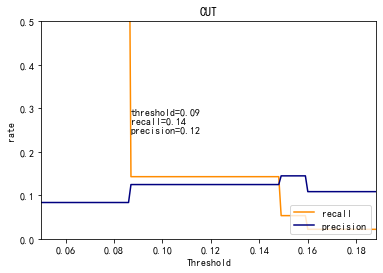

In [41]:
plt.plot(threshold, recall, color='darkorange', label='recall')
plt.plot(threshold, precision, color='navy', label='precision')
diff = list(abs(np.array(recall)-np.array(precision)))
best_threshold_1 = threshold[diff.index(min(diff))]
best_recall = recall[diff.index(min(diff))]
best_precision = precision[diff.index(min(diff))]
text = 'threshold='+str(round(best_threshold_1,2))+'\nrecall='+str(round(best_recall,2))+'\nprecision='+str(round(best_precision,2))
plt.xlim([0.05, max(y_pred_proba)-0.0001])
plt.ylim([0.0, 0.5])
plt.xlabel('Threshold')
plt.ylabel('rate')
plt.title('CUT')
plt.legend(loc="lower right")
plt.annotate(text, xy=(best_threshold_1, best_recall), xytext=(best_threshold_1, best_recall+0.1))

### 逾期率

In [42]:
sample_valid_predict = sample_cut.copy(deep=True)
sample_valid_predict['predict'] = [1 if x>=best_threshold_1 else 0 for x in sample_cut.apply(lambda x: classify(x, tree1)['con'], axis=1)]

In [43]:
concentration(sample_valid)

0.08987419942675365

In [44]:
sample_valid_predict.groupby('predict').apply(concentration)

predict
0    0.083626
1    0.150428
dtype: float64

In [45]:
Counter(sample_valid_predict['predict'])

Counter({0: 11248, 1: 1123})

## 预分箱提升树 

### 训练

In [46]:
tree2 = buildtree(df=pd.concat([x_train, y_train], axis=1), 
                 selectedcol=selected_cut, 
                 max_depth=3, 
                 min_samples_leaf=70
                )

In [47]:
printtree(tree2)

{0.0: 6755, 1.0: 667, 'con': 0.0933}
关联地址_3天内收货地址610米内被多个下单高套现风险新户使用_cut:(1.0, inf]?
T->{0.0: 1305, 1.0: 191, 'con': 0.1221}
	同盾近15天查询次数_cut:(9.0, inf]?
	T->{0.0: 338, 1.0: 65, 'con': 0.1627}
		关联地址_收货地址610米内30天内注册新户数_cut:(1.0, inf]?
		T->{0.0: 280, 1.0: 48, 'con': 0.1414}
		F->{1.0: 17, 0.0: 58, 'con': 0.2559}
	F->{0.0: 967, 1.0: 126, 'con': 0.108}
		百融按身份证号查询_近12个月申请其他的次数_cut:(3.0, inf]?
		T->{0.0: 506, 1.0: 86, 'con': 0.1372}
		F->{0.0: 461, 1.0: 40, 'con': 0.075}
F->{0.0: 5450, 1.0: 476, 'con': 0.0864}
	同盾近1800天查询次数_cut:(74.0, inf]?
	T->{0.0: 2543, 1.0: 174, 'con': 0.0685}
		关联地址_收货地址610米内30天内注册新户数_cut:(1.0, inf]?
		T->{0.0: 348, 1.0: 29, 'con': 0.087}
		F->{0.0: 2195, 1.0: 145, 'con': 0.0656}
	F->{0.0: 2907, 1.0: 302, 'con': 0.101}
		年龄_cut:(-inf, 29.0]?
		T->{0.0: 1399, 1.0: 124, 'con': 0.0868}
		F->{0.0: 1508, 1.0: 178, 'con': 0.1133}


### 验证

In [48]:
y_pred_proba = x_test.apply(lambda x: classify(x, tree2)['con'], axis=1)

In [49]:
threshold = []
recall,precision = [],[]
for t in np.arange(0.05,max(y_pred_proba)-0.0001,0.001):
    y_pred = np.array([1 if x>=t else 0 for x in y_pred_proba])
    recall.append(len([y1 for y1,y2 in zip(y_test, y_pred) if y1==1 and y2==1])/len([x for x in y_test if x==1]))
    precision.append(len([y1 for y1,y2 in zip(y_test, y_pred) if y1==1 and y2==1])/len([x for x in y_pred if x==1]))
    threshold.append(t)

Text(0.13800000000000007, 0.18716707021791767, 'threshold=0.14\nrecall=0.09\nprecision=0.12')

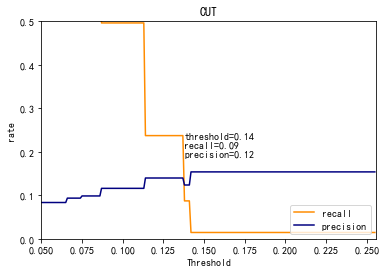

In [50]:
plt.plot(threshold, recall, color='darkorange', label='recall')
plt.plot(threshold, precision, color='navy', label='precision')
diff = list(abs(np.array(recall)-np.array(precision)))
best_threshold_2 = threshold[diff.index(min(diff))]
best_recall = recall[diff.index(min(diff))]
best_precision = precision[diff.index(min(diff))]
text = 'threshold='+str(round(best_threshold_2,2))+'\nrecall='+str(round(best_recall,2))+'\nprecision='+str(round(best_precision,2))
plt.xlim([0.05, max(y_pred_proba)-0.0001])
plt.ylim([0.0, 0.5])
plt.xlabel('Threshold')
plt.ylabel('rate')
plt.title('CUT')
plt.legend(loc="lower right")
plt.annotate(text, xy=(best_threshold_2, best_recall), xytext=(best_threshold_2, best_recall+0.1))

### 逾期率

In [51]:
sample_valid_predict = sample_cut.copy(deep=True)
sample_valid_predict['predict'] = [1 if x>=best_threshold_2 else 0 for x in sample_cut.apply(lambda x: classify(x, tree2)['con'], axis=1)]

In [52]:
concentration(sample_valid)

0.08987419942675365

In [53]:
sample_valid_predict.groupby('predict').apply(concentration)

predict
0    0.086653
1    0.148268
dtype: float64

In [54]:
Counter(sample_valid_predict['predict'])

Counter({0: 11677, 1: 694})

## 决策树

In [55]:
x = sample_valid[selected]
# x = selected_onehot_df
y = sample_valid[target]
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.4,random_state = 0)

### 训练

In [56]:
model = tree.DecisionTreeClassifier(max_depth=3
                                    ,min_samples_leaf=70
                                    ,class_weight='balanced'
#                                     ,class_weight={0:1, 1:10}
                                    ,random_state=0)
clf = model.fit(x_train,y_train)
# 预测标签
y_pred_proba = clf.predict_proba(x_test)[:,1]
print("测试集的平均正确率：{}".format(clf.score(x_test,y_test)))

# # 计算回归值，取值小于0，表示p(y=1) <0.5,则该处标签属于1，否则属于0
# y_pred1 = clf.predict_proba(x_test)

测试集的平均正确率：0.30288947262073146


In [57]:
sorted(list(zip(selected, model.feature_importances_)), key=lambda x: x[1], reverse=True)

[('同盾近1800天查询次数', 0.3812253557160401),
 ('年龄', 0.24221100588144798),
 ('百融按手机号查询_近6个月在非银机构最大月申请次数', 0.2016116441922788),
 ('关联地址_3天内收货地址610米内被多个下单高套现风险新户使用', 0.17495199421023314),
 ('关联地址_收货地址610米内30天内注册新户数', 0.0),
 ('同盾近15天查询次数', 0.0),
 ('手机号码_30天内紧急联系人关联多人借款下单', 0.0),
 ('手机号码_90天内紧急联系人关联多人高风险套现下单', 0.0),
 ('收货行为_检测省份和收货省份不一致', 0.0),
 ('百融按身份证号查询_近12个月申请其他的次数', 0.0)]

### 验证

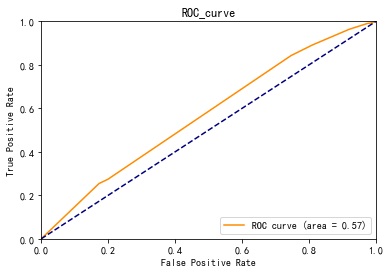

In [58]:
## 绘制ROC曲线并计算AUC的值
# fpr, tpr, threshold = roc_curve(y_train,clf.predict(x_train))
fpr, tpr, threshold = roc_curve(y_test,y_pred_proba)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
          label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_curve')
plt.legend(loc="lower right")

In [59]:
threshold = []
recall,precision = [],[]
for t in np.arange(0.5,min(0.7,max(y_pred_proba)-0.001),0.01):
    y_pred = np.array([1 if x>=t else 0 for x in y_pred_proba])
    recall.append(len([y1 for y1,y2 in zip(y_test, y_pred) if y1==1 and y2==1])/len([x for x in y_test if x==1]))
    precision.append(len([y1 for y1,y2 in zip(y_test, y_pred) if y1==1 and y2==1])/len([x for x in y_pred if x==1]))
    threshold.append(t)

Text(0.56, 0.3542372881355932, 'threshold=0.56\nrecall=0.25\nprecision=0.12')

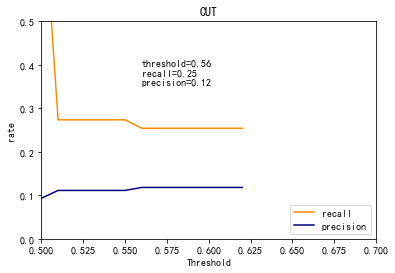

In [60]:
plt.plot(threshold, recall, color='darkorange', label='recall')
plt.plot(threshold, precision, color='navy', label='precision')
diff = list(abs(np.array(recall)-np.array(precision)))
best_threshold_3 = threshold[diff.index(min(diff))]
best_recall = recall[diff.index(min(diff))]
best_precision = precision[diff.index(min(diff))]
text = 'threshold='+str(round(best_threshold_3,2))+'\nrecall='+str(round(best_recall,2))+'\nprecision='+str(round(best_precision,2))
plt.xlim([0.5, 0.7])
plt.ylim([0.0, 0.5])
plt.xlabel('Threshold')
plt.ylabel('rate')
plt.title('CUT')
plt.legend(loc="lower right")
plt.annotate(text, xy=(best_threshold_3, best_recall), xytext=(best_threshold_3, best_recall+0.1))

### 逾期率

In [61]:
sample_valid_predict = sample_valid.copy(deep=True)
sample_valid_predict['predict'] = [1 if x>=best_threshold_3 else 0 for x in clf.predict_proba(sample_valid[selected])[:,1]]
# sample_valid_predict['predict'] = [1 if x>=best_threshold_3 else 0 for x in clf.predict_proba(selected_onehot_df)[:,1]]

In [62]:
concentration(sample_valid)

0.08987419942675365

In [63]:
sample_valid_predict.groupby('predict').apply(concentration)

predict
0    0.082571
1    0.125159
dtype: float64

In [64]:
Counter(sample_valid_predict['predict'])

Counter({0: 10193, 1: 2178})

### 画图

In [65]:
# import os
# os.environ["PATH"] += 'C:\\Users\\xx\\AppData\\Local\\Programs\\Python\\Python38\\Graphviz\\bin\\' + os.pathsep

# dot_data = tree.export_graphviz(clf, # 注意这个参数为决策树对象名称
#                                 out_file=None,
#                                 feature_names=selected, # 还需要指定特征名
#                                 class_names=target,
#                                 filled=True,
#                                 impurity=False,
#                                 rounded=True,
#                                 proportion=True,
#                                 rotate=True
#                                )

# graph = pydotplus.graph_from_dot_data(dot_data.replace('helvetica', 'MicrosoftYaHei'))
# # graph.get_nodes()[7].set_fillcolor("#FFF2DD")
# Image(graph.create_png())

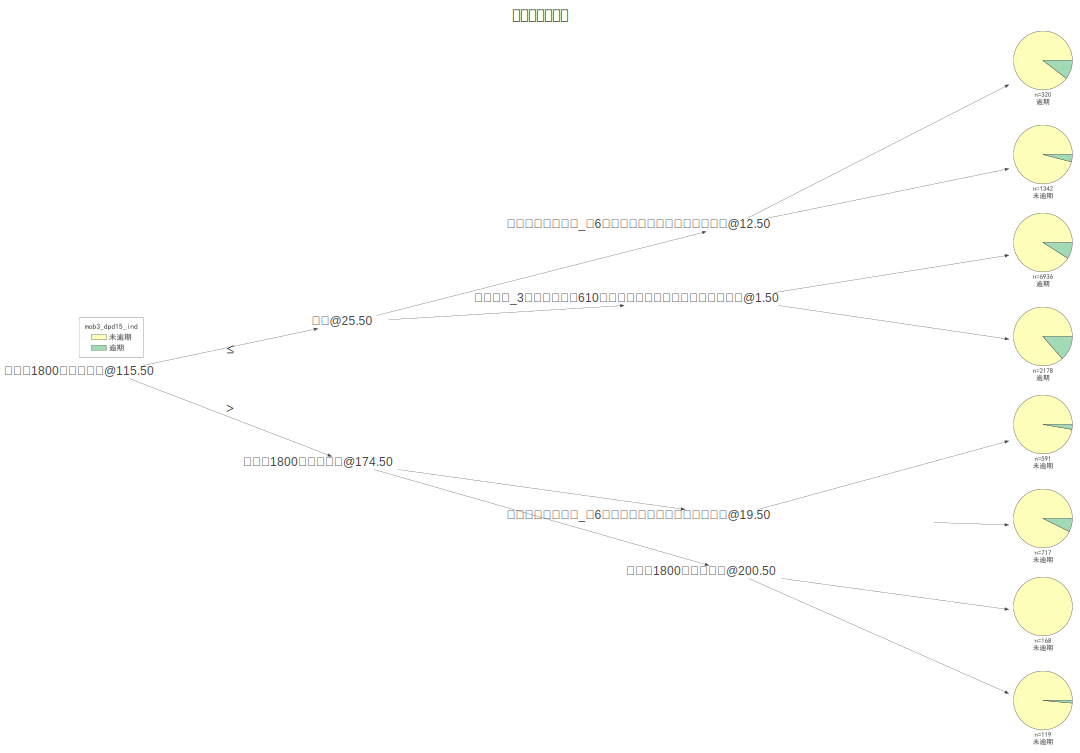

In [66]:
viz = dtreeviz(clf, 
               x_data=x,
               y_data=y,
               target_name=target,
               feature_names=selected,
#                feature_names=selected_category_ftr,
               class_names={0:'未逾期',1:'逾期'}, 
               title="高风险套现新户",
               orientation='LR',
               fontname='SimHei',
               fancy=False,
#                X=x_test.loc[32598]
              )
viz

## 随机森林

### 训练

In [141]:
rf_classifier = RandomForestClassifier(n_estimators=10
                                       ,max_depth=3
                                       ,min_samples_leaf=70
                                       ,class_weight='balanced'
                                       ,random_state=0)
clf2 = rf_classifier.fit(x_train,y_train)
# 预测标签
y_pred_proba_train = clf2.predict_proba(x_train)[:,1]
y_pred_proba_test = clf2.predict_proba(x_test)[:,1]
y_pred_proba_all = clf2.predict_proba(x)[:,1]
print("测试集的平均正确率：{}".format(clf2.score(x_test,y_test)))

# # 计算回归值，取值小于0，表示p(y=1) <0.5,则该处标签属于1，否则属于0
# y_pred1 = clf.predict_proba(x_test)

测试集的平均正确率：0.6540715296019398


In [96]:
sorted(list(zip(selected, rf_classifier.feature_importances_)), key=lambda x: x[1], reverse=True)

[('同盾近1800天查询次数', 0.32839846459841787),
 ('年龄', 0.18080577807607096),
 ('关联地址_收货地址610米内30天内注册新户数', 0.1518724164876105),
 ('同盾近15天查询次数', 0.09046226656577329),
 ('关联地址_3天内收货地址610米内被多个下单高套现风险新户使用', 0.07095784951466128),
 ('百融按身份证号查询_近12个月申请其他的次数', 0.06724552061157535),
 ('收货行为_检测省份和收货省份不一致', 0.05712098911311777),
 ('百融按手机号查询_近6个月在非银机构最大月申请次数', 0.03562746470529294),
 ('手机号码_30天内紧急联系人关联多人借款下单', 0.017509250327479943),
 ('手机号码_90天内紧急联系人关联多人高风险套现下单', 0.0)]

### 验证

ROC

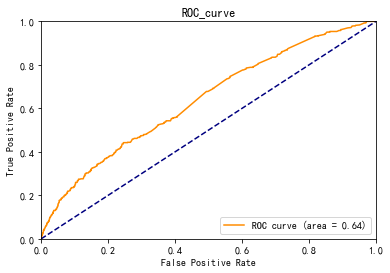

In [97]:
## 绘制ROC曲线并计算AUC的值
# fpr, tpr, threshold = roc_curve(y_train,clf.predict(x_train))
fpr, tpr, threshold = roc_curve(y_train,y_pred_proba_train)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
          label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_curve')
plt.legend(loc="lower right")

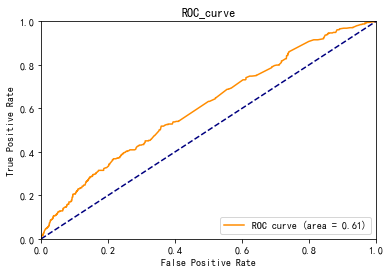

In [98]:
## 绘制ROC曲线并计算AUC的值
# fpr, tpr, threshold = roc_curve(y_train,clf.predict(x_train))
fpr, tpr, threshold = roc_curve(y_test,y_pred_proba_test)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
          label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_curve')
plt.legend(loc="lower right")

precision,recall

In [99]:
threshold = []
recall,precision = [],[]
for t in np.arange(0.5,max(y_pred_proba_test)-0.001,0.01):
    y_pred = np.array([1 if x>=t else 0 for x in y_pred_proba_test])
    recall.append(len([y1 for y1,y2 in zip(y_test, y_pred) if y1==1 and y2==1])/len([x for x in y_test if x==1]))
    precision.append(len([y1 for y1,y2 in zip(y_test, y_pred) if y1==1 and y2==1])/len([x for x in y_pred if x==1]))
    threshold.append(t)

Text(0.56, 0.24527845036319612, 'threshold=0.56\nrecall=0.15\nprecision=0.15')

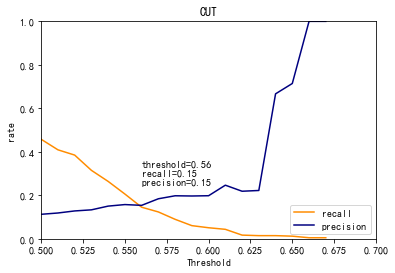

In [101]:
plt.plot(threshold, recall, color='darkorange', label='recall')
plt.plot(threshold, precision, color='navy', label='precision')
diff = list(abs(np.array(recall)-np.array(precision)))
best_threshold_4 = threshold[diff.index(min(diff))]
best_recall = recall[diff.index(min(diff))]
best_precision = precision[diff.index(min(diff))]
text = 'threshold='+str(round(best_threshold_4,2))+'\nrecall='+str(round(best_recall,2))+'\nprecision='+str(round(best_precision,2))
plt.xlim([0.5, 0.7])
plt.ylim([0.0, 1])
plt.xlabel('Threshold')
plt.ylabel('rate')
plt.title('CUT')
plt.legend(loc="lower right")
plt.annotate(text, xy=(best_threshold_4, best_recall), xytext=(best_threshold_4, best_recall+0.1))

KS

In [140]:
max(y_pred_proba_train*1000),max(y_pred_proba_test*1000)

(675.689400181014, 675.689400181014)

In [ ]:
b = [-np.inf]+[i for i in np.arange(0.5,0.67,0.01)] +[np.inf]

In [136]:
y_pred_proba_train_bin = pd.cut(y_pred_proba_train, b)
y_df = pd.DataFrame({'特征': y_pred_proba_train_bin, 't': y_train}).reset_index(drop=True)
get_ks(y_df)

,分箱,个数,坏样本,好样本,累计badrate,累计goodrate,累计lift,KS分量,KS,badratio
0,"(0.67, inf]",3.0,2.0,1.0,0.002999,0.000148,7.418291,0.002850,0.183518,0.666667
1,"(0.66, 0.67]",1.0,0.0,1.0,0.002999,0.000296,5.563718,0.002702,0.183518,0.000000
2,"(0.65, 0.66]",8.0,6.0,2.0,0.011994,0.000592,7.418291,0.011402,0.183518,0.750000
3,"(0.64, 0.65]",11.0,2.0,9.0,0.014993,0.001925,4.838016,0.013068,0.183518,0.181818
4,"(0.63, 0.64]",25.0,7.0,18.0,0.025487,0.004589,3.940967,0.020898,0.183518,0.280000
5,"(0.62, 0.63]",13.0,4.0,9.0,0.031484,0.005922,3.830757,0.025563,0.183518,0.307692
6,"(0.61, 0.62]",59.0,16.0,43.0,0.055472,0.012287,3.430960,0.043185,0.183518,0.271186
7,"(0.6, 0.61]",40.0,8.0,32.0,0.067466,0.017024,3.129591,0.050442,0.183518,0.200000
8,"(0.59, 0.6]",42.0,9.0,33.0,0.080960,0.021910,2.974661,0.059050,0.183518,0.214286
9,"(0.58, 0.59]",89.0,19.0,70.0,0.109445,0.032272,2.791419,0.077173,0.183518,0.213483


In [139]:
y_pred_proba_test_bin = pd.cut(y_pred_proba_test, b)
y_df = pd.DataFrame({'特征': y_pred_proba_test_bin, 't': y_test}).reset_index(drop=True)
get_ks(y_df)

,分箱,个数,坏样本,好样本,累计badrate,累计goodrate,累计lift,KS分量,KS,badratio
0,"(0.67, inf]",2.0,2.0,0.0,0.004843,0.000000,11.983051,0.004843,0.146452,1.000000
1,"(0.65, 0.66]",5.0,3.0,2.0,0.012107,0.000441,8.559322,0.011666,0.146452,0.600000
2,"(0.64, 0.65]",2.0,1.0,1.0,0.014528,0.000661,7.988701,0.013866,0.146452,0.500000
3,"(0.63, 0.64]",18.0,0.0,18.0,0.014528,0.004630,2.662900,0.009898,0.146452,0.000000
4,"(0.62, 0.63]",5.0,1.0,4.0,0.016949,0.005511,2.621292,0.011438,0.146452,0.200000
5,"(0.61, 0.62]",41.0,11.0,30.0,0.043584,0.012125,2.954725,0.031458,0.146452,0.268293
6,"(0.6, 0.61]",33.0,3.0,30.0,0.050847,0.018739,2.374001,0.032108,0.146452,0.090909
7,"(0.59, 0.6]",21.0,4.0,17.0,0.060533,0.022487,2.358868,0.038046,0.146452,0.190476
8,"(0.58, 0.59]",60.0,12.0,48.0,0.089588,0.033069,2.370978,0.056520,0.146452,0.200000
9,"(0.57, 0.58]",90.0,14.0,76.0,0.123487,0.049824,2.206266,0.073663,0.146452,0.155556


In [142]:
y_pred_proba_all_bin = pd.cut(y_pred_proba_all, b)
y_df = pd.DataFrame({'特征': y_pred_proba_all_bin, 't': y}).reset_index(drop=True)
get_ks(y_df)

,分箱,个数,坏样本,好样本,累计badrate,累计goodrate,累计lift,KS分量,KS,badratio
0,"(0.67, inf]",5.0,4.0,1.0,0.003704,0.000089,9.163704,0.003615,0.169068,0.800000
1,"(0.66, 0.67]",1.0,0.0,1.0,0.003704,0.000177,7.636420,0.003527,0.169068,0.000000
2,"(0.65, 0.66]",13.0,9.0,4.0,0.012037,0.000531,7.837378,0.011506,0.169068,0.692308
3,"(0.64, 0.65]",13.0,3.0,10.0,0.014815,0.001417,5.727315,0.013398,0.169068,0.230769
4,"(0.63, 0.64]",43.0,7.0,36.0,0.021296,0.004605,3.512753,0.016691,0.169068,0.162791
5,"(0.62, 0.63]",18.0,5.0,13.0,0.025926,0.005757,3.448706,0.020169,0.169068,0.277778
6,"(0.61, 0.62]",100.0,27.0,73.0,0.050926,0.012222,3.264273,0.038704,0.169068,0.270000
7,"(0.6, 0.61]",73.0,11.0,62.0,0.061111,0.017713,2.842126,0.043398,0.169068,0.150685
8,"(0.59, 0.6]",63.0,13.0,50.0,0.073148,0.022142,2.750504,0.051007,0.169068,0.206349
9,"(0.58, 0.59]",149.0,31.0,118.0,0.101852,0.032592,2.636003,0.069260,0.169068,0.208054


In [ ]:
b = [-np.inf]+[i for i in np.arange(0.5,0.67,0.02)] +[np.inf]

In [143]:
y_pred_proba_train_bin = pd.cut(y_pred_proba_train, b)
y_df = pd.DataFrame({'特征': y_pred_proba_train_bin, 't': y_train}).reset_index(drop=True)
get_ks(y_df)

,分箱,个数,坏样本,好样本,累计badrate,累计goodrate,累计lift,KS分量,KS,badratio
0,"(0.66, inf]",4.0,2.0,2.0,0.002999,0.000296,5.563718,0.002702,0.183518,0.500000
1,"(0.64, 0.66]",19.0,8.0,11.0,0.014993,0.001925,4.838016,0.013068,0.183518,0.421053
2,"(0.62, 0.64]",38.0,11.0,27.0,0.031484,0.005922,3.830757,0.025563,0.183518,0.289474
3,"(0.6, 0.62]",99.0,24.0,75.0,0.067466,0.017024,3.129591,0.050442,0.183518,0.242424
4,"(0.58, 0.6]",131.0,28.0,103.0,0.109445,0.032272,2.791419,0.077173,0.183518,0.213740
5,"(0.56, 0.58]",299.0,56.0,243.0,0.193403,0.068246,2.432948,0.125158,0.183518,0.187291
6,"(0.54, 0.56]",488.0,65.0,423.0,0.290855,0.130866,2.002526,0.159989,0.183518,0.133197
7,"(0.52, 0.54]",709.0,78.0,631.0,0.407796,0.224278,1.693712,0.183518,0.183518,0.110014
8,"(0.5, 0.52]",659.0,49.0,610.0,0.481259,0.314582,1.460305,0.166678,0.183518,0.074355
9,"(-inf, 0.5]",4976.0,346.0,4630.0,1.000000,1.000000,1.000000,0.000000,0.183518,0.069534


In [144]:
y_pred_proba_test_bin = pd.cut(y_pred_proba_test, b)
y_df = pd.DataFrame({'特征': y_pred_proba_test_bin, 't': y_test}).reset_index(drop=True)
get_ks(y_df)

,分箱,个数,坏样本,好样本,累计badrate,累计goodrate,累计lift,KS分量,KS,badratio
0,"(0.66, inf]",2.0,2.0,0.0,0.004843,0.000000,11.983051,0.004843,0.146452,1.000000
1,"(0.64, 0.66]",7.0,4.0,3.0,0.014528,0.000661,7.988701,0.013866,0.146452,0.571429
2,"(0.62, 0.64]",23.0,1.0,22.0,0.016949,0.005511,2.621292,0.011438,0.146452,0.043478
3,"(0.6, 0.62]",74.0,14.0,60.0,0.050847,0.018739,2.374001,0.032108,0.146452,0.189189
4,"(0.58, 0.6]",81.0,16.0,65.0,0.089588,0.033069,2.370978,0.056520,0.146452,0.197531
5,"(0.56, 0.58]",203.0,23.0,180.0,0.145278,0.072751,1.843546,0.072527,0.146452,0.113300
6,"(0.54, 0.56]",335.0,49.0,286.0,0.263923,0.135802,1.801590,0.128120,0.146452,0.146269
7,"(0.52, 0.54]",516.0,50.0,466.0,0.384988,0.238536,1.535298,0.146452,0.146452,0.096899
8,"(0.5, 0.52]",436.0,30.0,406.0,0.457627,0.328042,1.350505,0.129585,0.146452,0.068807
9,"(-inf, 0.5]",3272.0,224.0,3048.0,1.000000,1.000000,1.000000,0.000000,0.146452,0.068460


In [146]:
y_pred_proba_all_bin = pd.cut(y_pred_proba_all, b)
y_df = pd.DataFrame({'特征': y_pred_proba_all_bin, 't': y}).reset_index(drop=True)
get_ks(y_df)

,分箱,个数,坏样本,好样本,累计badrate,累计goodrate,累计lift,KS分量,KS,badratio
0,"(0.66, inf]",6.0,4.0,2.0,0.003704,0.000177,7.636420,0.003527,0.169068,0.666667
1,"(0.64, 0.66]",26.0,12.0,14.0,0.014815,0.001417,5.727315,0.013398,0.169068,0.461538
2,"(0.62, 0.64]",61.0,12.0,49.0,0.025926,0.005757,3.448706,0.020169,0.169068,0.196721
3,"(0.6, 0.62]",173.0,38.0,135.0,0.061111,0.017713,2.842126,0.043398,0.169068,0.219653
4,"(0.58, 0.6]",212.0,44.0,168.0,0.101852,0.032592,2.636003,0.069260,0.169068,0.207547
5,"(0.56, 0.58]",502.0,79.0,423.0,0.175000,0.070056,2.209107,0.104944,0.169068,0.157371
6,"(0.54, 0.56]",823.0,114.0,709.0,0.280556,0.132849,1.924988,0.147706,0.169068,0.138518
7,"(0.52, 0.54]",1225.0,128.0,1097.0,0.399074,0.230006,1.630431,0.169068,0.169068,0.104490
8,"(0.5, 0.52]",1095.0,79.0,1016.0,0.472222,0.319989,1.416896,0.152233,0.169068,0.072146
9,"(-inf, 0.5]",8248.0,570.0,7678.0,1.000000,1.000000,1.000000,0.000000,0.169068,0.069108


In [150]:
b = [-np.inf]+[i for i in np.arange(0.5,0.67,0.05)] +[np.inf]

In [151]:
y_pred_proba_train_bin = pd.cut(y_pred_proba_train, b)
y_df = pd.DataFrame({'特征': y_pred_proba_train_bin, 't': y_train}).reset_index(drop=True)
get_ks(y_df)

,分箱,个数,坏样本,好样本,累计badrate,累计goodrate,累计lift,KS分量,KS,badratio
0,"(0.65, inf]",12.0,8.0,4.0,0.011994,0.000592,7.418291,0.011402,0.166678,0.666667
1,"(0.6, 0.65]",148.0,37.0,111.0,0.067466,0.017024,3.129591,0.050442,0.166678,0.250000
2,"(0.55, 0.6]",652.0,113.0,539.0,0.236882,0.096817,2.165191,0.140064,0.166678,0.173313
3,"(0.5, 0.55]",1634.0,163.0,1471.0,0.481259,0.314582,1.460305,0.166678,0.166678,0.099755
4,"(-inf, 0.5]",4976.0,346.0,4630.0,1.000000,1.000000,1.000000,0.000000,0.166678,0.069534


In [152]:
y_pred_proba_test_bin = pd.cut(y_pred_proba_test, b)
y_df = pd.DataFrame({'特征': y_pred_proba_test_bin, 't': y_test}).reset_index(drop=True)
get_ks(y_df)

,分箱,个数,坏样本,好样本,累计badrate,累计goodrate,累计lift,KS分量,KS,badratio
0,"(0.65, inf]",7.0,5.0,2.0,0.012107,0.000441,8.559322,0.011666,0.129585,0.714286
1,"(0.6, 0.65]",99.0,16.0,83.0,0.050847,0.018739,2.374001,0.032108,0.129585,0.161616
2,"(0.55, 0.6]",434.0,64.0,370.0,0.205811,0.100309,1.886221,0.105502,0.129585,0.147465
3,"(0.5, 0.55]",1137.0,104.0,1033.0,0.457627,0.328042,1.350505,0.129585,0.129585,0.091469
4,"(-inf, 0.5]",3272.0,224.0,3048.0,1.000000,1.000000,1.000000,0.000000,0.129585,0.068460


In [153]:
y_pred_proba_all_bin = pd.cut(y_pred_proba_all, b)
y_df = pd.DataFrame({'特征': y_pred_proba_all_bin, 't': y}).reset_index(drop=True)
get_ks(y_df)

,分箱,个数,坏样本,好样本,累计badrate,累计goodrate,累计lift,KS分量,KS,badratio
0,"(0.65, inf]",19.0,13.0,6.0,0.012037,0.000531,7.837378,0.011506,0.152233,0.684211
1,"(0.6, 0.65]",247.0,53.0,194.0,0.061111,0.017713,2.842126,0.043398,0.152233,0.214575
2,"(0.55, 0.6]",1086.0,177.0,909.0,0.225000,0.098220,2.058783,0.126780,0.152233,0.162983
3,"(0.5, 0.55]",2771.0,267.0,2504.0,0.472222,0.319989,1.416896,0.152233,0.152233,0.096355
4,"(-inf, 0.5]",8248.0,570.0,7678.0,1.000000,1.000000,1.000000,0.000000,0.152233,0.069108


### 逾期率

In [74]:
sample_valid_predict = sample_valid.copy(deep=True)
# sample_valid_predict['predict'] = [1 if x>=best_threshold_4 else 0 for x in clf2.predict_proba(sample_valid[selected])[:,1]]
sample_valid_predict['predict'] = [1 if x>=0.65 else 0 for x in clf2.predict_proba(sample_valid_predict[selected])[:,1]]
# sample_valid_predict['predict'] = [1 if x>=best_threshold_4 else 0 for x in clf2.predict_proba(selected_onehot_df)[:,1]]
# sample_valid_predict['predict'] = [1 if x>=0.63 else 0 for x in clf2.predict_proba(selected_onehot_df)[:,1]]

In [75]:
concentration(sample_valid)

0.08987419942675365

In [76]:
sample_valid_predict.groupby('predict').apply(concentration)

predict
0    0.089147
1    0.693545
dtype: float64

In [77]:
Counter(sample_valid_predict['predict'])

Counter({0: 12352, 1: 19})

In [155]:
x_train.shape[0], x_test.shape[0]

(7422, 4949)

### 画图

In [78]:
# import os
# os.environ["PATH"] += 'C:\\Users\\xx\\AppData\\Local\\Programs\\Python\\Python38\\Graphviz\\bin\\' + os.pathsep

# # 随机森林画图
# i=0
# for per_rf in rf_classifier.estimators_:
#     dot_data = tree.export_graphviz(per_rf,
#                                     out_file=None,
#                                     feature_names=selected, # 还需要指定特征名
#                                     class_names=target,
#                                     filled=True,
#                                     impurity=False,
#                                     rounded=True,
#                                     proportion=True,
#                                     rotate=True
#                                    )
#     graph = pydotplus.graph_from_dot_data(dot_data.replace('helvetica', 'MicrosoftYaHei'))
#     # graph.get_nodes()[7].set_fillcolor("#FFF2DD")
# #     Image(graph.create_png())
#     graph.write_pdf("./output/"+str(i)+"DTtree.pdf")
# #     break
#     i = i+1

In [79]:
# 随机森林画图
i=0
for per_rf in rf_classifier.estimators_:
    viz = dtreeviz(per_rf, 
                   x_data=x,
                   y_data=y,
                   target_name=target,
                   feature_names=selected,
#                    feature_names=selected_category_ftr, 
                   class_names={0:'未逾期',1:'逾期'}, 
                   title="高风险套现新户",
                   orientation='LR',
                   fontname='SimHei',
                   fancy=False,
    #                X=x_test.loc[32598]
                  )
    viz.save("./output/"+str(i)+"DTtree.svg")
    viz.view()
    i = i+1

# 单观察点

In [80]:
repayinfo[repayinfo['注册手机']==18502675260][['注册手机','下单时间','品类','收货地址']+selected].reset_index(drop=True)

,注册手机,下单时间,品类,收货地址,关联地址_3天内收货地址610米内被多个下单高套现风险新户使用,关联地址_收货地址610米内30天内注册新户数,同盾近15天查询次数,同盾近1800天查询次数,年龄,手机号码_30天内紧急联系人关联多人借款下单,手机号码_90天内紧急联系人关联多人高风险套现下单,收货行为_检测省份和收货省份不一致,百融按手机号查询_近6个月在非银机构最大月申请次数,百融按身份证号查询_近12个月申请其他的次数
0,18502675260,2022-06-14,高风险套现,四川省 成都市 龙泉驿区 第九空间大厦1812,9,30,5,67,41,0,1,1,10,5
1,18502675260,2022-06-13,高风险套现,四川省 成都市 龙泉驿区 第九空间大厦1812,14,30,5,67,41,0,1,0,10,5
2,18502675260,2022-06-17,高风险套现,四川省 成都市 龙泉驿区 第九空间大厦1812,11,30,5,67,41,0,1,1,10,5
3,18502675260,2022-06-14,高风险套现,四川省 成都市 龙泉驿区 第九空间大厦1812,9,30,5,67,41,0,1,1,10,5
4,18502675260,2022-06-14,高风险套现,四川省 成都市 龙泉驿区 第九空间大厦1812,9,30,5,67,41,0,1,1,10,5


In [81]:
tmp_fp_df = repayinfo[repayinfo['注册手机']==18502675260][selected].reset_index(drop=True)
tmp_fp_df

,关联地址_3天内收货地址610米内被多个下单高套现风险新户使用,关联地址_收货地址610米内30天内注册新户数,同盾近15天查询次数,同盾近1800天查询次数,年龄,手机号码_30天内紧急联系人关联多人借款下单,手机号码_90天内紧急联系人关联多人高风险套现下单,收货行为_检测省份和收货省份不一致,百融按手机号查询_近6个月在非银机构最大月申请次数,百融按身份证号查询_近12个月申请其他的次数
0,9,30,5,67,41,0,1,1,10,5
1,14,30,5,67,41,0,1,0,10,5
2,11,30,5,67,41,0,1,1,10,5
3,9,30,5,67,41,0,1,1,10,5
4,9,30,5,67,41,0,1,1,10,5


In [82]:
clf2.predict_proba(tmp_fp_df.loc[[0],:])[0][-1]

0.5674913811981818

In [83]:
for per_rf in rf_classifier.estimators_:
    ep = explain_prediction_path(per_rf, x=tmp_fp_df.loc[0], feature_names=selected, explanation_type="plain_english")
    pp = per_rf.predict_proba(tmp_fp_df.loc[[0],:])[0][-1]
    if pp>=best_threshold_4:
        print(str(pp)+'\n'+ep)

0.7787050027976077
40.5 <= 年龄 
0.5 <= 收货行为_检测省份和收货省份不一致 

0.7466518485172474
4.5 <= 关联地址_收货地址610米内30天内注册新户数 
4.5 <= 同盾近15天查询次数 
33.5 <= 年龄 

0.6658404269076231
2.5 <= 关联地址_收货地址610米内30天内注册新户数 
3.5 <= 百融按身份证号查询_近12个月申请其他的次数 

0.7015826855321294
2.5 <= 关联地址_收货地址610米内30天内注册新户数 
65.5 <= 同盾近1800天查询次数 
1.5 <= 百融按身份证号查询_近12个月申请其他的次数 

0.5975988410740443
1.5 <= 关联地址_3天内收货地址610米内被多个下单高套现风险新户使用 
24.5 <= 年龄 
0.5 <= 收货行为_检测省份和收货省份不一致 

0.5627565557947302
1.5 <= 关联地址_收货地址610米内30天内注册新户数 
同盾近15天查询次数 < 13.5
25.5 <= 年龄 



In [84]:
tmp_fp_df2 = repayinfo[repayinfo['注册手机']==18502675260][selected+[target]+['fpd15amo','fpd15amosum']].reset_index(drop=True)

In [85]:
tmp_fp_df_cut = tmp_fp_df2.copy(deep=True)
for s in selected:
    tmp_fp_df_cut[s+'_cut'] = pd.cut(tmp_fp_df_cut[s], [-np.inf, float(sift_df[sift_df['特征']==s]['maxliftcut']), np.inf])

In [86]:
classify(tmp_fp_df2.loc[0], tree1, p=1)

手机号码_90天内紧急联系人关联多人高风险套现下单 >= 1
同盾近15天查询次数 < 17
年龄 >= 41


{1.0: 61, 0.0: 379, 'con': 0.1486}

In [87]:
classify(tmp_fp_df_cut.loc[0], tree2, p=1)

关联地址_3天内收货地址610米内被多个下单高套现风险新户使用_cut 不等于 (1.0, inf]
同盾近1800天查询次数_cut 不等于 (74.0, inf]
年龄_cut 不等于 (-inf, 29.0]


{0.0: 1508, 1.0: 178, 'con': 0.1133}

# 模型保存

In [154]:
# joblib.dump(clf2, './output/rf_20220802.model')

['./output/rf_20220802.model']

In [88]:
# from odps import ODPS
# from odps.df import DataFrame

# o = ODPS('LTAI4G4xSRz19v5d2UPmGvB2', 'RZt7RaVAPgC0eEQtvIzD622PCnTh25', project='basestone_rs_dev')
# # order_history_table = DataFrame(o.get_table('order_history_table_shl')).to_pandas()

# def read_sql_query(odps, sql):
#     """
#     :param odps:
#     :param sql:
#     :return: pandas DataFrame
#     """
#     try:
#         readers_ = odps.execute_sql(sql).open_reader()
#         col_name = [i.name for i in readers_.schema]
 
#         data = pd.concat([pd.DataFrame({column: [value] for column, value in zip(col_name, reader.values)}) for reader in readers_])
#     except Exception as e:
#         data = pd.DataFrame({'info':[e]})
#         print(e)
#     finally:
#         return data

# tmp_repayinfo_shl2 = read_sql_query(odps=o, sql= """
# select a.订单号
# , b.fpd3_ind as oot_fpd3_ind
# , b.fpd7_ind as oot_fpd7_ind
# , b.fpd15_ind as oot_fpd15_ind
# from tmp_fraud_shl a
# left join (select * from bt_order_loan_back_info where dt=0000) b
# on a.订单号=b.order_code
# where a.fd3_ind=0 and b.fd3_ind=1
# """
# )

# sample_valid2 = pd.merge(left=tmp_repayinfo_shl2, right=repayinfo, how='left', on='订单号')